<h2 style="text-align:center; font-size:40px; font-weight:bold"> CAPTCHA READER</h2>

<img src="https://static.wixstatic.com/media/390a76_653e9d5e8e1a4421bbbea0bcf53201bb~mv2.png/v1/fill/w_640,h_366,al_c,lg_1,q_85,enc_auto/390a76_653e9d5e8e1a4421bbbea0bcf53201bb~mv2.png" height="500" width="1500">

A CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) is a security mechanism designed to differentiate between human users and automated bots on the internet. It is a challenge-response test that is intended to determine whether the user is a human or a machine.

Today, I'm going  to extract CAPTCHA details from images using a machine learning approach using PyTorch. I'll be testing different settings to see how well the model works and will keep track of everything by saving the results, including logs and model information, in a specific location known as weight and baises (wandb).

<h3 style="text-align:center; font-weight:bold; font-size:30px"> Data Preprocessing</h3>

First, I'll import the necessary libraries. Feel free to use similar libraries that match your chosen framework. For instance, if you're using TensorFlow for extracting text from CAPTCHA images, TensorFlow's `keras.layers.StringLookup` can work, or you can create a character-to-number mapping dictionary.

Now, let's talk about the dataset. The dataset consists of CAPTCHA images, and each image's filename corresponds to the actual text within it. To start, we need to split the filenames from their extensions and store them in a list. Simultaneously, we should also save the file paths of each image in another list. Additionally, it's important to convert all the unique characters found in the CAPTCHAs into numerical representations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch 
import torch.nn as nn
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import cv2
from itertools import groupby
import wandb
from kaggle_secrets import UserSecretsClient

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
img_dir = Path("/kaggle/input/captcha-dataset/samples")

In [3]:
img_dir

PosixPath('/kaggle/input/captcha-dataset/samples')

In [4]:
all_images = list(map(str, list(img_dir.glob("*.png"))))
labels = [ image.split(os.path.sep)[-1].split(".png")[0] for image in all_images]
unique_characters = {ch for chars in labels for ch in chars}
unique_characters = sorted(list(unique_characters))

In [5]:
len(unique_characters)

19

In [6]:
unique_characters.insert(0, '_')

In [7]:
print(unique_characters)

['_', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [8]:
len(unique_characters)

20

In [9]:
max_length = max(len(label) for label in labels) 
max_length

5

In [10]:
lb = LabelEncoder()


In [11]:
lb.fit(unique_characters)

LabelEncoder()

In [12]:
each_chars = [[ch for ch in chars] for chars in labels]

In [13]:
len(each_chars)

1040

In [14]:
targets = lb.transform(np.array(each_chars).flatten())
targets = targets.reshape(1040,5)

In [15]:
# targets = targets + 1
targets = torch.tensor(targets)

<h3 style="text-align:center; font-weight:bold; font-size:30px">Weight and Baises(Wandb)</h3>

 Wandb is is a tool used for visualizing and tracking machine learning experiments. You can use wandb to log and monitor various aspects of your machine learning project, including hyperparameters, metrics, model architectures, and more.
 
In a Kaggle kernel environment, you have two options for logging into wandb

(1) Interactive Login:
    Run a code cell containing wandb.login(). It will prompt you to enter your W&B API key, which you can copy and paste in the input prompt.

(2) Using Kaggle Secrets:
   You can leverage Kaggle Secrets to securely store your W&B API key. Then, you can employ the code snippet below to log in without explicitly displaying your API key in your code.

After logging into wandb, I will set up a configuration file to gather all the hyperparameters. Feel free to include any other hyperparameters you'd like. These can then be passed to wandb using the <b>wand.init</b> function. This way, you'll have a centralized place to manage and track your experiment settings.

In [16]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("my-captcha")
wandb.login(key=wandb_api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
config = { "batch_size":16,
          "epochs":90,
          "learning_rate":0.001,
          "image_size":(200,50),
          "drop_out":0.2,
          "optimizer":"Adam",
          "data_split":"90:10"  
}

In [18]:
run = wandb.init(project="CAPTCHA-CRACKER",name = "run11", config = config)

wandb: Currently logged in as: bishowlamsal233 (ai-viper). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230827_113549-0nin3cfw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run run11
wandb: ⭐️ View project at https://wandb.ai/ai-viper/CAPTCHA-CRACKER
wandb: 🚀 View run at https://wandb.ai/ai-viper/CAPTCHA-CRACKER/runs/0nin3cfw


<h3 style="text-align:center; font-weight:bold; font-size:30px">Creating Custom Dataset Class</h3>
Creating a custom dataset class in PyTorch serves several important purposes when working with data for machine learning tasks.

(i) PyTorch provides the torch.utils.data.Dataset class where you can create you own dataset and apply preprocessing steps (such as resizing images, normalizing data, etc.), and transforming data on-the-fly during training.

(ii) PyTorch's DataLoader class enables efficient data loading in mini-batches during training. A custom dataset class allows you to seamlessly integrate your dataset with the DataLoader, making it convenient to shuffle, batch, and parallelize data loading.

(iii)With a custom dataset class, you have control over how data samples are indexed and sampled..

(iv) Once you've created a custom dataset class, you can reuse it across different projects or experiments without duplicating data loading and preprocessing code. This promotes code reusability and saves time when starting new projects.


I've fully used the features that are mentioned above by designing a custom dataset class called CaptchaDataset. Within this class, I've implemented image processing technique like image resizing to efficiently load and iterate through both image and label indices. This seamless integration is optimized to align seamlessly with the batch size specified by the data loader, enhancing the overall training process.

In [19]:
class CaptchaDataset(Dataset):
    
    def __init__(self, img_dir, labels):
        self.img_path = img_dir
        self.label = labels
        self.transform = transforms.Compose([
                                              transforms.Resize(config["image_size"], antialias=True)
                                              ])
        
    def __len__(self):
       return len(self.img_path)

    def __getitem__(self, idx):
        image = cv2.imread(self.img_path[idx],0)
        image = cv2.resize(image, config["image_size"])
        image = image / 255.0
        image = torch.tensor(image)
        targets = self.label[idx]

        return {"image" : image,
                "labels" : targets}
        
        

In [20]:
all_images_arr = np.array(all_images)


In [21]:
encoded_labels= np.array(each_chars)
encoded_labels

array([['6', 'n', '6', 'g', 'g'],
       ['f', 'n', 'c', 'n', 'b'],
       ['n', 'b', 'w', 'n', 'n'],
       ...,
       ['3', 'b', 'n', 'y', 'f'],
       ['x', 'n', 'n', '4', 'd'],
       ['3', '7', 'd', '5', '2']], dtype='<U1')

In [22]:
targets

tensor([[ 4, 15,  4, 13, 13],
        [12, 15,  9, 15,  8],
        [15,  8, 17, 15, 15],
        ...,
        [ 1,  8, 15, 19, 12],
        [18, 15, 15,  2, 10],
        [ 1,  5, 10,  3,  0]])

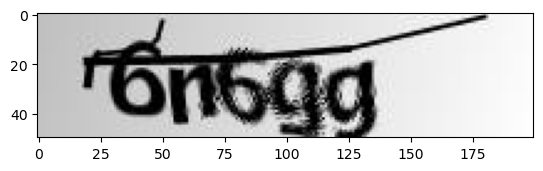

In [23]:
imgs = plt.imread(all_images_arr[0])
plt.imshow(imgs, cmap="gray")

In [24]:
X_train,X_val, y_train, y_val = train_test_split(all_images_arr, targets, test_size = 0.10)

In [25]:
total_length = len(X_val)
total_length

104

In [26]:
test_ratio = int(0.2*total_length)
validation_size = total_length-test_ratio
validation_size

84

In [27]:
X_test = X_val[validation_size:]
y_test = y_val[validation_size:]

In [28]:
print("The length of the test image is ", len(X_test))
print("The length of the test label is ", len(y_test))

The length of the test image is  20
The length of the test label is  20


In [29]:
X_val =  X_val[:validation_size]
y_val = y_val[:validation_size]

In [30]:
print("The length of the validation image is ", len(X_val))
print("The length of the validation label is ", len(y_val))

The length of the validation image is  84
The length of the validation label is  84


In [31]:
train_ds = CaptchaDataset(img_dir = X_train, labels = y_train)
validation_ds = CaptchaDataset(img_dir = X_val, labels = y_val)
test_ds = CaptchaDataset(img_dir = X_val, labels = y_val)

In [32]:
batch_size = config["batch_size"]
train_dataloader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_ds,  batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

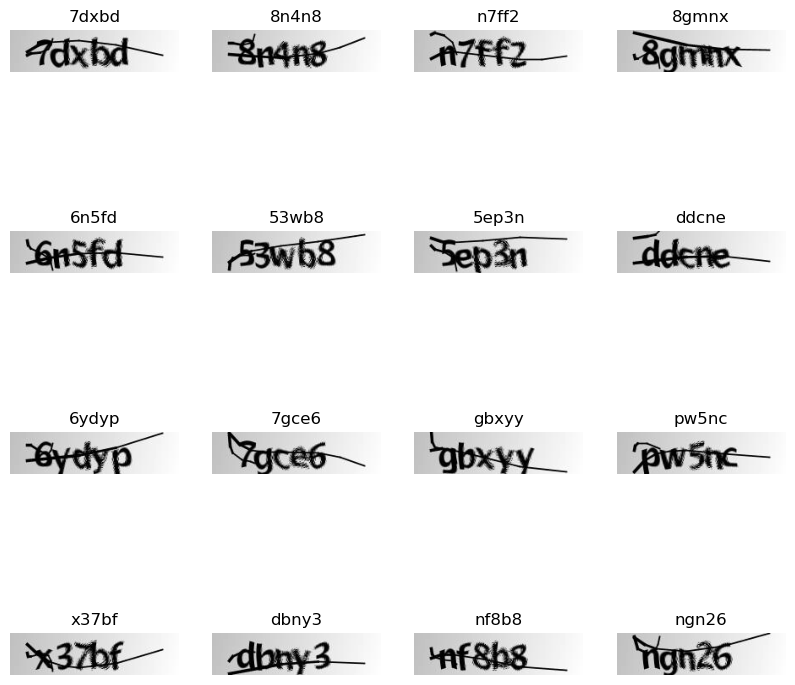

In [34]:
image_list = []
label_list = []
for data in train_dataloader:
    images = data["image"]
    label = data["labels"]
    for image, label in (zip(images, label)):
        image_list.append(np.array(image))
        label_list.append(np.array(label))
    break

_, axes = plt.subplots(batch_size//4, 4, figsize=(10,10))
axes = axes.ravel()
for i, (image, label) in enumerate(zip(image_list, label_list)):
    label = "".join(lb.inverse_transform(label).tolist())
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show();    

<h3 style="text-align:center; font-weight:bold; font-size:30px"> Creation of CRNN Model</h3>

In our project, we are using  the CRNN (Convolutional Recurrent Neural Network) architecture, which combines convolutional and recurrent layers.  CRNNs are primarily used for tasks related to sequence recognition, such as text recognition in images. Here are the steps we are going to extract text from the image:

(i) We initiate by applying a convolutional filter twice with a 3x3 kernel over an image of size (200, 50). Concurrently, we employ max-pooling to capture significant features within the image. These convolutional layer's outputs are then flattened to form a feature vector, which serves as input for a fully connected layer.

(ii) This vector is subsequently fed into a bidirectional Long Short-Term Memory (LSTM) network, which preserves the sequence order of characters, a critical aspect in sequence recognition tasks.

(iii) To finalize the model's predictions, we employ an output layer with neurons corresponding to the total number of characters in our case, which is 20.

(iv) While prediction is a key goal, equally important is the comparison of predictions with actual labels to calculate the loss. To this end, we utilize the CTC loss function.

(v) CTC loss stands out for its ability to align input sequences of varying lengths with output sequences of differing lengths, without necessitating a one-to-one alignment.The CTC alignments give us a natural way to go from probabilities at each time-step to the probability of an output sequence. For more information check-out: https://distill.pub/2017/ctc/


![](https://www.researchgate.net/publication/350973207/figure/fig1/AS:1014287988453376@1618836509707/The-architecture-of-CRNN-for-OCR.jpg)

In [35]:
class CaptchaNeuralNetwork(nn.Module):
    def __init__(self, n_chars):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, (3,3), stride = 2, padding =2)
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(2,2), stride=1)
        self.conv2 = nn.Conv2d(128, 64, (3,3), stride =2, padding=2)
        self.maxpooling2 = nn.MaxPool2d(kernel_size =(2,2), stride=1)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(64*13, 32)
        self.dropout = nn.Dropout(config["drop_out"])
        self.lstm1 = nn.LSTM(32, 64, num_layers = 1, bidirectional = True)
        self.output = nn.Linear(128, n_chars+1)
    
    def forward(self, image, target_output=None):
        
        batch, channel, height = image.shape[0], image.shape[1], image.shape[2]
        image = image.unsqueeze(1)
        layer1 = self.relu(self.conv1(image))
        layer1 = self.maxpooling1(layer1)
        batch, channel, height, width = layer1.shape[0], layer1.shape[1], layer1.shape[2], layer1.shape[3]
        layer2 = self.relu(self.conv2(layer1))
        layer2 = self.maxpooling2(layer2)
        inputs = layer2.permute((0, 3, 1, 2))
        inputs = inputs.view(batch, inputs.size(1), -1)
        inputs = self.relu(self.linear1(inputs))
        inputs = self.dropout(inputs)
        inputs, _ = self.lstm1(inputs)
        output = self.output(inputs)
        output = output.permute(1, 0, 2)
        if target_output is not None:
            log_softmax_output = nn.functional.log_softmax(output, dim = 2)
            input_lengths = torch.full(size=(batch,),fill_value = log_softmax_output.size(0), dtype = torch.int32)
            target_lengths = torch.full(size=(batch,),fill_value = target_output.size(1), dtype = torch.int32)
            ctc_loss = nn.CTCLoss(blank=0)
            loss = ctc_loss(log_softmax_output, target_output, input_lengths, target_lengths)
            return output, loss
        return output, None
        


In [36]:
model= CaptchaNeuralNetwork(19).to(device)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr = config["learning_rate"])

<h3 style="text-align:center; font-weight:bold; font-size:30px"> Training And Evaluating The Model Performance</h3>
Well, it's time to train our model, and simultaneously validating our model accuracy on the validation dataset. Moreover,if the model's accuracy doesn't improve after 5 rounds of learning we are going to stop it. At last, we return the model and test on new data. 


<b>Note:</b> In the meantime, we are also using wandb inorder to analyse the model performance based on the parameters we have used for it.  

In [38]:
 def train_model(model, device, train_loader, validation_loader):
        
     """This function is used to train the model and evaluating the validation dataset based on the
     performance for each epoch"""
        
     model.train()
     for epoch in range(config["epochs"]):
          train_loss = 0.0
          for data in train_dataloader:
             image, label = data["image"].to(torch.float32), data["labels"]
             image, label = image.to(device), label.to(device)
             optimizer.zero_grad()
             _, loss = model(image, label)
             train_loss +=  loss.item()
             loss.backward()
             optimizer.step()
              
          model.eval()
          val_loss = 0
          correct_val_pred = 0
          threshold_loss = 1e-4
          patience = 5
          best_loss = float('inf')
          current_patience = 0
          counter = 0
          with torch.no_grad():
            for ims in validation_dataloader:
                image, label = ims["image"].to(torch.float32), ims["labels"]
                image, label = image.to(device), label.to(device)
                val_output, new_loss = model(image, label)
                val_loss += new_loss 
            if val_loss< best_loss:
                best_loss = val_loss
                counter=0
            else:
                counter+=1
                print("after counter", counter)
                if counter>=patience:
                    print("early stopping")
                    break
          avg_training_loss = train_loss / len(train_dataloader)
          avg_val_loss = val_loss / len(validation_dataloader)
          model.train()
          wandb.log({"loss":avg_training_loss, "val_loss": avg_val_loss})
          print(f"Epoch:[{epoch+1}/{config['epochs']}], TRAINING Loss:{avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
     return model

In [39]:
len(validation_dataloader)

6

In [40]:
wandb.watch(model, optimizer, log="all", log_freq=10) 
model = train_model(model, device, train_dataloader, validation_dataloader)

Epoch:[1/90], TRAINING Loss:5.8603, Validation Loss: 2.8752
Epoch:[2/90], TRAINING Loss:2.8952, Validation Loss: 2.8294
Epoch:[3/90], TRAINING Loss:2.8823, Validation Loss: 2.8160
Epoch:[4/90], TRAINING Loss:2.8761, Validation Loss: 2.8211
Epoch:[5/90], TRAINING Loss:2.8729, Validation Loss: 2.8096
Epoch:[6/90], TRAINING Loss:2.8674, Validation Loss: 2.8078
Epoch:[7/90], TRAINING Loss:2.8682, Validation Loss: 2.8065
Epoch:[8/90], TRAINING Loss:2.8664, Validation Loss: 2.8138
Epoch:[9/90], TRAINING Loss:2.8640, Validation Loss: 2.8003
Epoch:[10/90], TRAINING Loss:2.8653, Validation Loss: 2.7970
Epoch:[11/90], TRAINING Loss:2.8596, Validation Loss: 2.8048
Epoch:[12/90], TRAINING Loss:2.8548, Validation Loss: 2.7977
Epoch:[13/90], TRAINING Loss:2.8464, Validation Loss: 2.7763
Epoch:[14/90], TRAINING Loss:2.8310, Validation Loss: 2.7345
Epoch:[15/90], TRAINING Loss:2.7223, Validation Loss: 2.4718
Epoch:[16/90], TRAINING Loss:2.3833, Validation Loss: 2.0922
Epoch:[17/90], TRAINING Loss:2.02

In [41]:
def evaluting_model(model, test_loader, device):
    
    """This function is used for evaluating the test data using the
    trained model and return two list where one contains the actual
    label and another contain label predicted by model"""
    
    actual_output = []
    prediction_output = []
    with torch.no_grad():
        for ims in test_loader:
            image, label = ims["image"].to(torch.float32), ims["labels"]
            image, label = image.to(device), label.to(device)
            output, loss = model(image, label)
            actual_output.append(image.cpu().numpy())
            prediction_output.append(output)
        return actual_output, prediction_output
            

In [42]:
actual_output, prediction_output = evaluting_model(model, test_dataloader, device)

In [43]:
def decode_prediction(prediction_output, actual_output):
    output_lst = []
    for output in prediction_output:
        preds = output.permute(1,0,2)
        preds = torch.softmax(preds, 2)
        preds = torch.argmax(preds, 2)
        for i in range(preds.shape[0]):
            output = preds[i]
            output = output.tolist()
            filtered_data = np.array([key for key, _ in groupby(output) if key != 0])
            converted_output = " ".join(lb.inverse_transform(filtered_data))
            output_lst.append(converted_output)
        return output_lst

In [44]:
output_lst = decode_prediction(prediction_output, actual_output)

In [45]:
output_lst

['g c 8 3 b',
 'f 4 f n',
 'e 4 3 y n',
 'b e 6 n p',
 'f 8 3 3 p n',
 'x x 7 d',
 'p m g 5 5',
 '3 7 3 g b',
 '5 7 b 7',
 'g p x n',
 '8 3 4 8',
 '6 8 4 n',
 '4 4 e',
 '3 x 3 5',
 'y y 8 4',
 'y g g g']

<h3 style="text-align:center; font-weight:bold; font-size:30px"> Prediction on Test Data</h3>
We can see our model has correctly predicted some of the captcha words, however, still we need add more dataset in order to make our model more generalized.

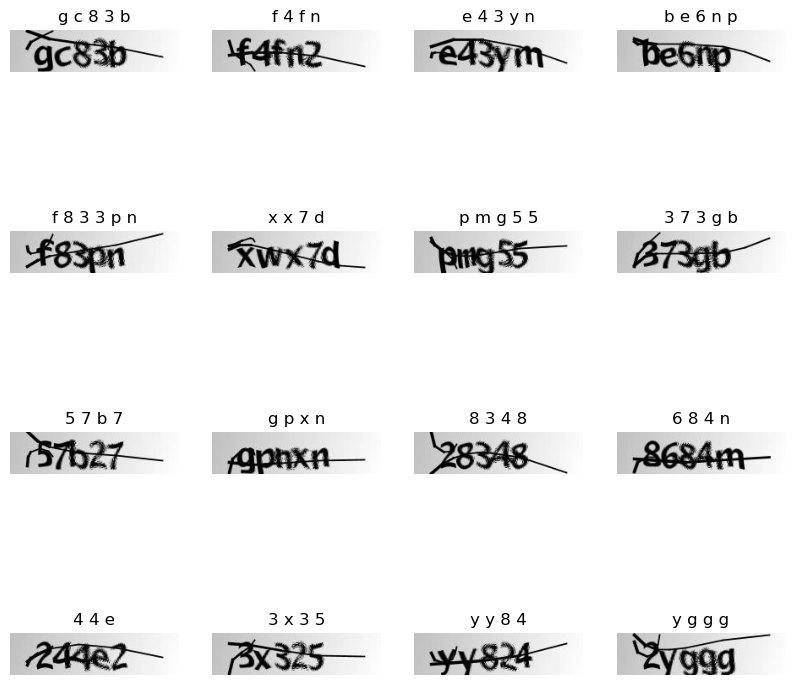

In [46]:
_, axes = plt.subplots(batch_size//4, 4, figsize=(10,10))
axes = axes.ravel()
for i, (image, label) in enumerate(zip(actual_output[0], output_lst)):
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show(); 

In [47]:
torch.save(model.state_dict(), "model.pt")
wandb.save('model.pt')

['/kaggle/working/wandb/run-20230827_113549-0nin3cfw/files/model.pt']

In [48]:
run.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:     loss █▄▄▄▄▄▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_loss ███████▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:     loss 0.02966
wandb: val_loss 0.01371
wandb: 
wandb: 🚀 View run run11 at: https://wandb.ai/ai-viper/CAPTCHA-CRACKER/runs/0nin3cfw
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20230827_113549-0nin3cfw/logs
